In [1]:
import os
import xarray as xr
import numpy as np
from pyhomogeneity import pettitt_test
import matplotlib.pyplot as plt
from scipy import stats

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm
import pymannkendall as mk

/home/r/Roshan.Jha/.local/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.21.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


In [2]:
data_path = ('../ERA5_UVTH/')
uwind_daily =[]
for year in range(1973, 2023):
    #print(year)
    file_path = os.path.join(data_path,f'{year}_UVTH.nc')
    uvth = xr.open_dataset(file_path)
    u = uvth.u
    uwnd = u.resample(time='D').mean()
    uwind_daily.append(uwnd)
    
uwind = xr.concat(uwind_daily,dim='time')

In [5]:
#Finding mean for each year
uwind_MAM = uwind.groupby('time.year').mean(dim='time')

In [7]:
def uwind_diff(zonal_wind,level):
    levs=level
    uwnd_MAM = zonal_wind.sel(level=levs)
    R1_uwind = uwnd_MAM.sel(year = slice("1973","1997"))
    R2_uwind = uwnd_MAM.sel(year = slice("1998","2022"))

    diff_R2_R1 = R2_uwind.mean(dim=['year']) - R1_uwind.mean(dim=['year'])

    ###############t-test with unequal variance#########################################################
    lats = uwnd_MAM.latitude.values
    lons = uwnd_MAM.longitude.values

    result = np.zeros([len(lats),len(lons)])
    sig = np.zeros([len(lats),len(lons)])
    sig[:] = np.nan

    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(R1_uwind[0,i,j])):
                result[i,j] = np.nan
            else:
                t, p = stats.ttest_ind(R1_uwind[:,i,j], R2_uwind[:,i,j],equal_var=False) 
                result[i,j]=t
                if p<0.05:
                    sig[i,j]=1


    uwind_Regime = xr.Dataset({"1973-1997": (('lat','lon'), R1_uwind.mean(dim=['year']).values),
                           "1998-2022": (('lat','lon'), R2_uwind.mean(dim=['year']).values),
                           "dif": (('lat','lon'), diff_R2_R1.values),
                           "sig": (('lat','lon'), sig)},
                           coords={'lat': lats, 'lon': lons})

    return uwind_Regime

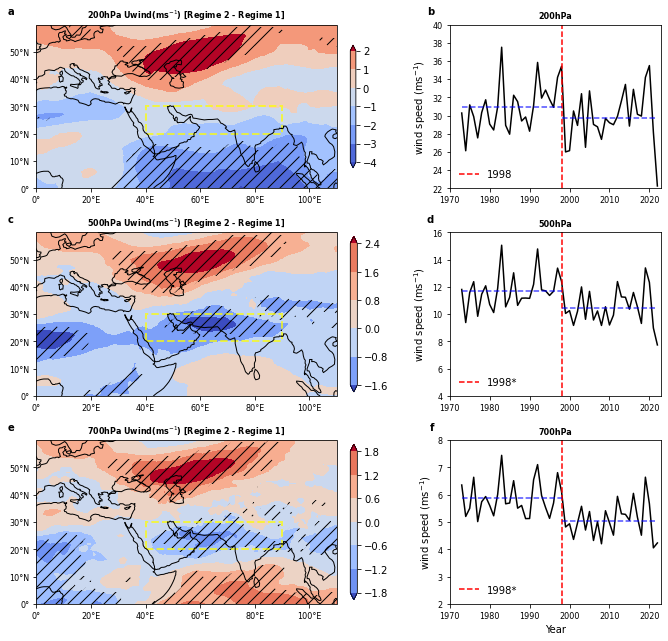

In [17]:
# Set up the figure with cartopy projection
fig = plt.figure(figsize=(10,9))

ax5 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())

uwind_Regime_200 = uwind_diff(uwind_MAM,200)
pvalue_mask = np.where(uwind_Regime_200.sig == 1, 1, np.nan)
# Set the pivot value for the colormap at 0 using TwoSlopeNorm
min_value = uwind_Regime_200.dif.min()
max_value = uwind_Regime_200.dif.max()
norm = TwoSlopeNorm(vmin=min_value, vmax=max_value, vcenter=0)

# Plot the trend data using contourf
diff_plot = ax5.contourf(uwind_Regime_200.lon, uwind_Regime_200.lat, uwind_Regime_200.dif, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both',norm=norm)

# Add a colorbar
cbar = fig.colorbar(diff_plot,ax=ax5,orientation='vertical', pad=0.03, shrink=0.75)
#cbar.set_label('°C')

# Add hatching to the sections where p-value is 1
hatch_plot = ax5.contourf(uwind_Regime_200.lon, uwind_Regime_200.lat, pvalue_mask, hatches=['//'],cmap='gray', alpha=0,  transform=ccrs.PlateCarree())

# hatch_transparency = 0.7  # Set desired transparency value (0 to 1)
# for hatch_collection in hatch_plot.collections:
#     hatch_collection.set_edgecolor((0, 0, 0, hatch_transparency))  # Set hatch color and transparency

rect_coords = [40, 20, 90, 30]  # [lon_min, lat_min, lon_max, lat_max]
 # Add a rectangular box to the plot with specific lat,lon coordinates
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='yellow', facecolor='none',alpha=0.7, transform=ccrs.PlateCarree())
ax5.add_patch(rect)


# Add coastlines and gridlines
ax5.coastlines()
# Crop the plot

# Longitude labels
ax5.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax5.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax5.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax5.tick_params(axis='both', which='major', labelsize=8)

ax5.set_extent([0, 110, 0, 60],crs=ccrs.PlateCarree())

# ax3.set_xlabel('Longitude')
# ax3.set_ylabel('Latitude')
 
# Title
ax5.set_title('200hPa Uwind(ms$^{-1}$) [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax5.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax5.transAxes,color='k', weight='bold')



####################################
ax6 = plt.subplot2grid(shape=(3, 3), loc=(0, 2), colspan=1, fig=fig)

u = uwind_MAM.sel(latitude=slice(30,20),longitude=slice(40,90),level=200).mean(dim=['latitude','longitude'])
res = pettitt_test(u)

# Pettitt test result
change_point = res.cp
cp_year = u.year[change_point-1].values
mu1 = round(res.avg.mu1,2)
mu2 = round(res.avg.mu2,2)  
pval = res.p
# Data
years = u.year

# Plot data and trend lines
ax6.plot(years, u, color='black',linestyle='solid')

if pval < 0.05:
    ax6.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}*')
else:
    ax6.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}')

ax6.plot([1973, years[change_point-1]], [mu1, mu1], color='b', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_era}')
ax6.plot([years[change_point-1],2022], [mu2, mu2], color='b', linestyle='--', alpha=0.7) #,label=f'Regime 2 Mean: {mu2_era}')
ax6.set_xlim(1970,2023)
ax6.set_ylim(22,40)

# Labels and legend
ax6.set_ylabel('wind speed (ms$^{-1}$)', fontsize=10)
ax6.legend(loc='lower left',frameon=False, ncol=1)
ax6.tick_params(axis='both', which='major', labelsize=8)
ax6.set_title('200hPa',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax6.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax6.transAxes,color='k', weight='bold')


############################################# 
ax1 = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())

uwind_Regime_500 = uwind_diff(uwind_MAM,500)
pvalue_mask = np.where(uwind_Regime_500.sig == 1, 1, np.nan)
# Set the pivot value for the colormap at 0 using TwoSlopeNorm
min_value = uwind_Regime_500.dif.min()
max_value = uwind_Regime_500.dif.max()
norm = TwoSlopeNorm(vmin=min_value, vmax=max_value, vcenter=0)

# Plot the trend data using contourf
diff_plot = ax1.contourf(uwind_Regime_500.lon, uwind_Regime_500.lat, uwind_Regime_500.dif, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both',norm=norm)

# Add a colorbar
cbar = fig.colorbar(diff_plot,ax=ax1,orientation='vertical', pad=0.03, shrink=0.95)
#cbar.set_label('°C')

# Add hatching to the sections where p-value is 1
hatch_plot = ax1.contourf(uwind_Regime_500.lon, uwind_Regime_500.lat, pvalue_mask, hatches=['//'],cmap='gray', alpha=0,  transform=ccrs.PlateCarree())

# hatch_transparency = 0.7  # Set desired transparency value (0 to 1)
# for hatch_collection in hatch_plot.collections:
#     hatch_collection.set_edgecolor((0, 0, 0, hatch_transparency))  # Set hatch color and transparency

rect_coords = [40, 20, 90, 30]  # [lon_min, lat_min, lon_max, lat_max]
 # Add a rectangular box to the plot with specific lat,lon coordinates
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='yellow', facecolor='none',alpha=0.7, transform=ccrs.PlateCarree())
ax1.add_patch(rect)


# Add coastlines and gridlines
ax1.coastlines()
# Crop the plot

# Longitude labels
ax1.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax1.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_extent([0, 110, 0, 60],crs=ccrs.PlateCarree())

# ax3.set_xlabel('Longitude')
# ax3.set_ylabel('Latitude')
 
# Title
ax1.set_title('500hPa Uwind(ms$^{-1}$) [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax1.text(-0.075, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')


############################################# 
ax2 = plt.subplot2grid(shape=(3, 3), loc=(1, 2), colspan=1, fig=fig)

u = uwind_MAM.sel(latitude=slice(30,20),longitude=slice(40,90),level=500).mean(dim=['latitude','longitude'])
res = pettitt_test(u)

# Pettitt test result
change_point = res.cp
cp_year = u.year[change_point-1].values
mu1 = round(res.avg.mu1,2)
mu2 = round(res.avg.mu2,2)  
pval = res.p
# Data
years = u.year

# Plot data and trend lines
ax2.plot(years, u, color='black',linestyle='solid')

if pval < 0.05:
    ax2.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}*')
else:
    ax2.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}')

ax2.plot([1973, years[change_point-1]], [mu1, mu1], color='b', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_era}')
ax2.plot([years[change_point-1],2022], [mu2, mu2], color='b', linestyle='--', alpha=0.7) #,label=f'Regime 2 Mean: {mu2_era}')
ax2.set_xlim(1970,2023)
ax2.set_ylim(4,16)

# Labels and legend
ax2.set_ylabel('wind speed (ms$^{-1}$)', fontsize=10)
ax2.legend(loc='lower left',frameon=False, ncol=1)
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_title('500hPa',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax2.text(-0.075, 1.05, 'd',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')



#############################################
ax3 = plt.subplot2grid(shape=(3, 3), loc=(2, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())

uwind_Regime_700 = uwind_diff(uwind_MAM,700)
pvalue_mask = np.where(uwind_Regime_700.sig == 1, 1, np.nan)
# Set the pivot value for the colormap at 0 using TwoSlopeNorm
min_value = uwind_Regime_700.dif.min()
max_value = uwind_Regime_700.dif.max()
norm = TwoSlopeNorm(vmin=min_value, vmax=max_value, vcenter=0)

# Plot the trend data using contourf
diff_plot = ax3.contourf(uwind_Regime_700.lon, uwind_Regime_700.lat, uwind_Regime_700.dif, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both',norm=norm)

# Add a colorbar
cbar = fig.colorbar(diff_plot,ax=ax3,orientation='vertical', pad=0.03, shrink=0.95)
#cbar.set_label('°C')

# Add hatching to the sections where p-value is 1
hatch_plot = ax3.contourf(uwind_Regime_700.lon, uwind_Regime_700.lat, pvalue_mask, hatches=['//'],cmap='gray', alpha=0,  transform=ccrs.PlateCarree())

# hatch_transparency = 0.7  # Set desired transparency value (0 to 1)
# for hatch_collection in hatch_plot.collections:
#     hatch_collection.set_edgecolor((0, 0, 0, hatch_transparency))  # Set hatch color and transparency

rect_coords = [40, 20, 90, 30]  # [lon_min, lat_min, lon_max, lat_max]
 # Add a rectangular box to the plot with specific lat,lon coordinates
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='yellow', facecolor='none',alpha=0.7, transform=ccrs.PlateCarree())
ax3.add_patch(rect)

# Add coastlines and gridlines
ax3.coastlines()
# Crop the plot

# Longitude labels
ax3.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax3.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax3.tick_params(axis='both', which='major', labelsize=8)

ax3.set_extent([0, 110, 0, 60],crs=ccrs.PlateCarree())

# ax3.set_xlabel('Longitude')
# ax3.set_ylabel('Latitude')
 
# Title
ax3.set_title('700hPa Uwind(ms$^{-1}$) [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax3.text(-0.075, 1.05, 'e',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')


############################################# 
ax4 = plt.subplot2grid(shape=(3, 3), loc=(2, 2), colspan=1, fig=fig)
u = uwind_MAM.sel(latitude=slice(30,20),longitude=slice(40,90),level=700).mean(dim=['latitude','longitude'])
res = pettitt_test(u)

# Pettitt test result
change_point = res.cp
cp_year = u.year[change_point-1].values
mu1 = round(res.avg.mu1,2)
mu2 = round(res.avg.mu2,2)  
pval = res.p

# Data
years = u.year

# Plot data and trend lines
ax4.plot(years, u,color='black',linestyle='solid')

if pval < 0.05:
    ax4.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}*')
else:
    ax4.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}')

ax4.plot([1973, years[change_point-1]], [mu1, mu1], color='b', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_era}')
ax4.plot([years[ change_point-1],2022], [mu2, mu2], color='b', linestyle='--', alpha=0.7) #,label=f'Regime 2 Mean: {mu2_era}')
ax4.set_xlim(1970,2023)
ax4.set_ylim(2,8)

# Labels and legend
ax4.set_ylabel('wind speed (ms$^{-1}$)', fontsize=10)
ax4.legend(loc='lower left',frameon=False, ncol=1)
ax4.set_ylabel('wind speed (ms$^{-1}$)', fontsize=10)
ax4.tick_params(axis='both', which='major', labelsize=8)
ax4.set_title('700hPa',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax4.set_xlabel('Year', fontsize=10) 
ax4.text(-0.075, 1.05, 'f',verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes,color='k', weight='bold')

plt.tight_layout()
plt.savefig('Figure_S2.png', dpi=600,bbox_inches='tight')
plt.savefig('Figure_S2.pdf', dpi=600,bbox_inches='tight')

In [10]:
u = uwind_MAM.sel(latitude=slice(30,20),longitude=slice(40,90),level=200).mean(dim=['latitude','longitude'])
res = pettitt_test(u)

# Pettitt test result
change_point = res.cp
cp_year = u.year[change_point-1].values
mu1 = round(res.avg.mu1,2)
mu2 = round(res.avg.mu2,2)  
pval = res.p
# Data
years = u.year

In [ ]:
# Set up the figure with cartopy projection
fig = plt.figure(figsize=(8,2.5))

############################################# First Subplot ############################################
ax1 = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())

uwind_Regime_200 = uwind_diff(uwind_MAM,200)
pvalue_mask = np.where(uwind_Regime_200.sig == 1, 1, np.nan)
# Set the pivot value for the colormap at 0 using TwoSlopeNorm
min_value = uwind_Regime_200.dif.min()
max_value = uwind_Regime_200.dif.max()
norm = TwoSlopeNorm(vmin=min_value, vmax=max_value, vcenter=0)

# Plot the trend data using contourf
diff_plot = ax1.contourf(uwind_Regime_200.lon, uwind_Regime_200.lat, uwind_Regime_200.dif, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both',norm=norm)

# Add a colorbar
cbar = fig.colorbar(diff_plot,ax=ax1,orientation='vertical', pad=0.03, shrink=0.75)
#cbar.set_label('°C')

# Add hatching to the sections where p-value is 1
hatch_plot = ax1.contourf(uwind_Regime_200.lon, uwind_Regime_200.lat, pvalue_mask, hatches=['//'],cmap='gray', alpha=0,  transform=ccrs.PlateCarree())

# hatch_transparency = 0.7  # Set desired transparency value (0 to 1)
# for hatch_collection in hatch_plot.collections:
#     hatch_collection.set_edgecolor((0, 0, 0, hatch_transparency))  # Set hatch color and transparency

rect_coords = [40, 20, 90, 30]  # [lon_min, lat_min, lon_max, lat_max]
 # Add a rectangular box to the plot with specific lat,lon coordinates
lon_min, lat_min, lon_max, lat_max = rect_coords
width = lon_max - lon_min
height = lat_max - lat_min
rect = Rectangle((lon_min, lat_min), width, height,  linewidth=2, linestyle='--', edgecolor='yellow', facecolor='none',alpha=0.7, transform=ccrs.PlateCarree())
ax1.add_patch(rect)


# Add coastlines and gridlines
ax1.coastlines()
# Crop the plot

# Longitude labels
ax1.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax1.set_yticks(np.arange(0,60,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)

# Set the font size for the x and y tick labels
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_extent([0, 110, 0, 60],crs=ccrs.PlateCarree())

# ax3.set_xlabel('Longitude')
# ax3.set_ylabel('Latitude')
 
# Title
ax1.set_title('200hPa Uwind(ms$^{-1}$) [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')



####################################
ax2 = plt.subplot2grid(shape=(1, 3), loc=(0, 2), colspan=1, fig=fig)

u = uwind_MAM.sel(latitude=slice(30,20),longitude=slice(40,90),level=200).mean(dim=['latitude','longitude'])
res = pettitt_test(u)

# Pettitt test result
change_point = res.cp
cp_year = u.year[change_point-1].values
mu1 = round(res.avg.mu1,2)
mu2 = round(res.avg.mu2,2)  
pval = res.p
# Data
years = u.year

# Plot data and trend lines
ax2.plot(years, u, color='black',linestyle='solid')

if pval < 0.05:
    ax2.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}*')
else:
    ax2.axvline(x=years[change_point-1], color='r', linestyle='--', label=f'{cp_year}')

ax2.plot([1973, years[change_point-1]], [mu1, mu1], color='b', linestyle='--',alpha=0.7) #, label=f'Regime 1 Mean: {mu1_era}')
ax2.plot([years[change_point-1],2022], [mu2, mu2], color='b', linestyle='--', alpha=0.7) #,label=f'Regime 2 Mean: {mu2_era}')
ax2.set_xlim(1970,2023)
ax2.set_ylim(18,36)

# Labels and legend
ax2.set_ylabel('wind speed (ms$^{-1}$)', fontsize=10)
ax2.legend(loc='lower left',frameon=False, ncol=1)
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_title('200hPa',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax2.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')



plt.tight_layout()
plt.savefig('X:/Roshan/PhD_Project_3/Figures/Pngs/Figure_S2.png', dpi=600,bbox_inches='tight')
plt.savefig('X:/Roshan/PhD_Project_3/Figures/Pdfs/Figure_S2.pdf', dpi=600,bbox_inches='tight')
